In [63]:
%matplotlib inline

import sys
sys.path.append('./lib')

from PIL import Image
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

import sklearn
import sklearn.decomposition
import yuv

from msssim import MultiScaleSSIM

# Video loading

In [64]:
# NOTE(ajayjain): This list may be missing a video
videos = [
    "./data/live/rh1_25fps.yuv",
    "./data/live/st1_25fps.yuv",
    "./data/live/pa1_25fps.yuv",
    "./data/live/tr1_25fps.yuv",
    "./data/live/bs1_25fps.yuv",
    "./data/live/mc1_50fps.yuv",
    "./data/live/sf1_25fps.yuv",
    "./data/live/rb1_25fps.yuv",
    "./data/live/sh1_50fps.yuv",
    "./data/live/pr1_50fps.yuv",
]

# Frame dimensions
dim = (768, 432)

In [65]:
video_matrix, frames = yuv.load_YUV420_video(videos[0], dim)

/home/ajay/.virtualenvs/compression/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


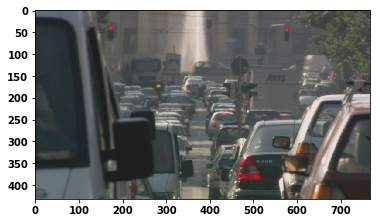

In [67]:
rgb_frames = yuv.convert_pil_ycbcr_to_rgb(frames)
stacked_frames = np.concatenate(rgb_frames)
plt.imshow(stacked_frames[:dim[1]*1, :, :])

In [7]:
def frame_vector_to_rgb(frame, dimensions):
    """Converts a image vector an RGB numpy array.
   
    Args:
        frame: vector of YUV data, scaled from 0 to 1
        dimensions: tuple/list/ndarray containing the width and height of the desired frame
    """
    Y_components = dimensions[0] * dimensions[1]
    U_components = Y_components // 4
    V_components = Y_components // 4
    
    UV_dimensions = (dimensions[0] // 2, dimensions[1] // 2)
   
    frame = np.uint8(frame * 255)

    y = Image.frombytes('L', dimensions, frame[:Y_components])
    u = Image.frombytes('L', UV_dimensions, frame[Y_components:Y_components+U_components])\
             .resize(dimensions)
    v = Image.frombytes('L', UV_dimensions, frame[Y_components+U_components:Y_components+U_components+V_components])\
             .resize(dimensions)

    image = Image.merge('YCbCr', (y, u, v)).convert('RGB')
    return image

# Non-negative matrix factorization of video byte matrix

In [100]:
import pickle

factorizations = {}

for video_path in videos:
    print("Loading {}".format(video_path))
    video_matrix, frames = yuv.load_YUV420_video(videos[0], dim)
    
    # Scale pixel values from 0 to 1
    video_matrix = video_matrix.T
    video_matrix = video_matrix.astype(np.float32) / 255.
    
    for n_components in range(5, 55, 5):
        print("Fitting NMF with {} components".format(n_components))
        nmf = sklearn.decomposition.NMF(n_components=n_components, verbose=True)
        W = nmf.fit_transform(video_matrix)
        H = nmf.components_
        factorizations[(video_path, n_components)] = (nmf, W, H)
        
pickle.dump(factorizations, "./results/factorizations.pkl")

Loading ./data/live/rh1_25fps.yuv
Fitting NMF with 5 components
violation: 1.0
violation: 0.44452661850125436
violation: 0.3156244806214722
violation: 0.2549477519882929
violation: 0.215712470053101
violation: 0.19014934333595282
violation: 0.17089307299631398
violation: 0.15630406121354676
violation: 0.14488411040935695
violation: 0.13567534246337212
violation: 0.12792302821141954
violation: 0.12137734143629987
violation: 0.11552493730817205
violation: 0.11048611224661431
violation: 0.10616368162989753
violation: 0.10238304243960801
violation: 0.09907329998534511
violation: 0.09615110380656144
violation: 0.09349714208603782
violation: 0.091095412050265
violation: 0.08881661767338092
violation: 0.0865874275266788
violation: 0.08453066220623696
violation: 0.08271363836729745
violation: 0.08112291275969846
violation: 0.07964007119003778
violation: 0.07824722327585057
violation: 0.07691578815691676
violation: 0.07562382981256562
violation: 0.0743706445947195
violation: 0.07315622898935867

KeyboardInterrupt: 

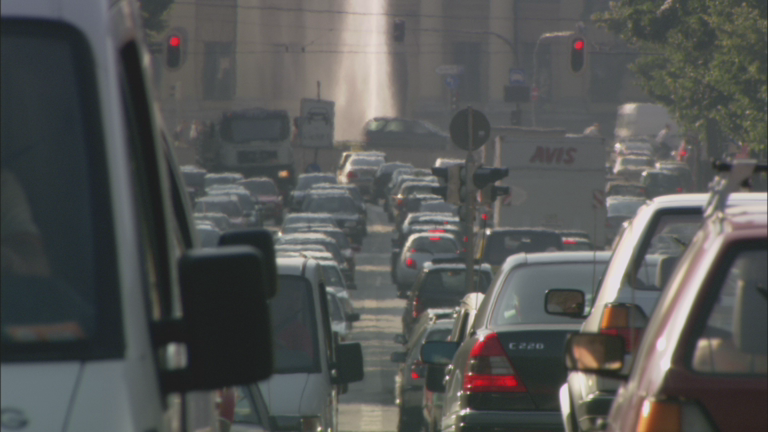

In [8]:
# Transpose video matrix: num frames by num components
frames = video_matrix.T
# Scale from 0 to 1
frames = frames.astype(np.float32) / 255.

frame_vector_to_rgb(frames[0], dim)

# eps = 1e-5
# frame_mean = frames.mean(axis=0)
# frame_std = frames.std(axis=0) + eps
# frames = (frames - frame_mean) / frame_std

In [11]:
nmf = sklearn.decomposition.NMF(n_components=10, verbose=True)
W = nmf.fit_transform(frames)

violation: 1.0
violation: 0.487850221182412
violation: 0.35823827648629153
violation: 0.2795289753560403
violation: 0.21789006779177125
violation: 0.17616670236913257
violation: 0.1472997344128942
violation: 0.12645553695489037
violation: 0.11109340782569842
violation: 0.09924554158784034
violation: 0.08985474686237746
violation: 0.08211106409173861
violation: 0.07575041244998705
violation: 0.07046091927978076
violation: 0.06610257533900614
violation: 0.062345153679915256
violation: 0.05906210159927777
violation: 0.05617583875745829
violation: 0.053592006325000455
violation: 0.05126305554645711
violation: 0.04915538785805924
violation: 0.0471918165235205
violation: 0.045364087360623834
violation: 0.043651682041566386
violation: 0.04203785996019861
violation: 0.04050150520273596
violation: 0.039044411399029706
violation: 0.03764947752562536
violation: 0.036322001144597015
violation: 0.03505782817993528
violation: 0.033846294377252104
violation: 0.03268849021525148
violation: 0.031590893

In [12]:
H = nmf.components_

In [13]:
# reconstructed = (W_uint8.astype(np.float32) / 255.) @ (H_uint8.astype(np.float32) / 255.)
reconstructed = np.float16(W) @ np.float16(H)

In [14]:
bytes_to_transmit = W.shape[0] * W.shape[1] * 2 + H.shape[0] * H.shape[1] * 2
original_bytes = video_matrix.shape[0] * video_matrix.shape[1]
compression_ratio = bytes_to_transmit / float(original_bytes)

bits_per_pixel = bytes_to_transmit * 8 / (dim[0] * dim[1] * video_matrix.shape[1])
original_bits_per_pixel = original_bytes * 8 / (dim[0] * dim[1] * video_matrix.shape[1])

print("Compressed bits/px: {:.3f}".format(bits_per_pixel))
print("Original bits/px:   {:.3f}".format(original_bits_per_pixel))
print("Compression ratio:  {:.3f}".format(compression_ratio))

Compressed bits/px: 0.960
Original bits/px:   12.000
Compression ratio:  0.080


/home/ajay/.virtualenvs/compression/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


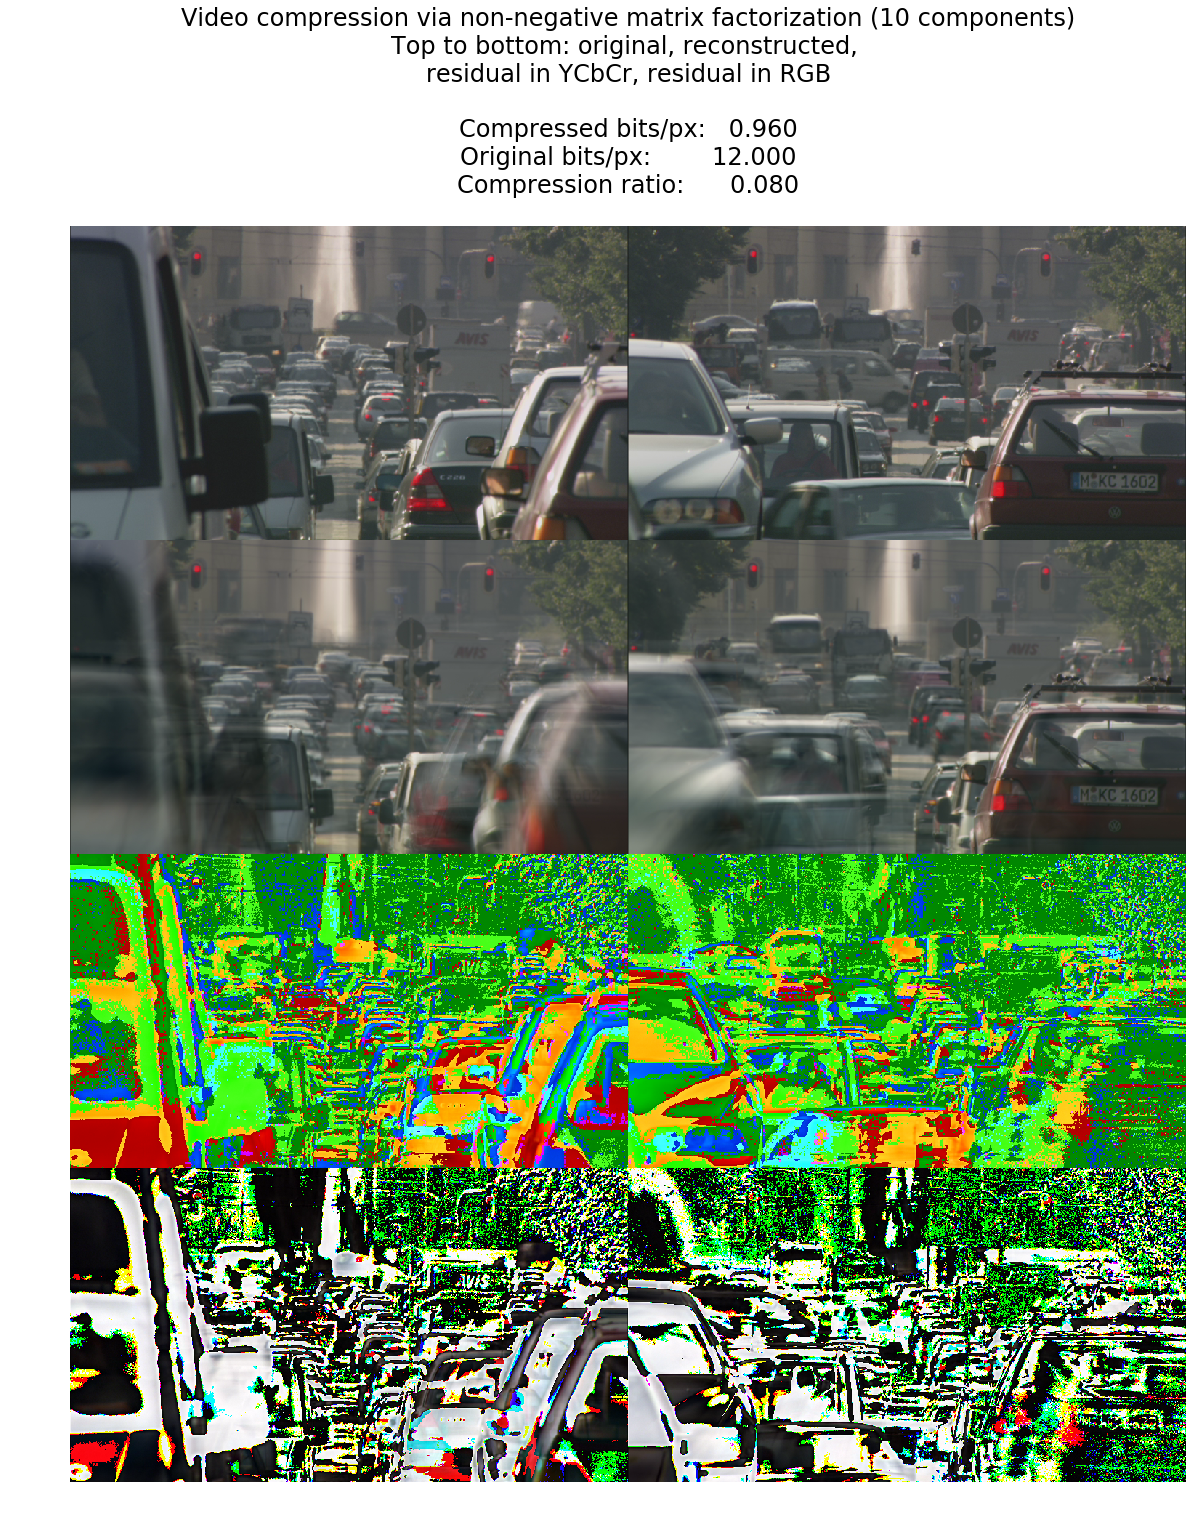

In [34]:
reconstructed_and_original = (
    frame_vector_to_rgb(reconstructed[0], dim),
    frame_vector_to_rgb(frames[0], dim)
)

plt.figure(figsize=(20, 30))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
title = "Video compression via non-negative matrix factorization (10 components)\n" +\
        "Top to bottom: original, reconstructed, \nresidual in YCbCr, residual in RGB\n\n" +\
        "Compressed bits/px:   {:.3f}\n".format(bits_per_pixel) +\
        "Original bits/px:        {:.3f}\n".format(original_bits_per_pixel) +\
        "Compression ratio:      {:.3f}\n".format(compression_ratio)
plt.title(title)
plt.axis("off")
plt.imshow(
    np.hstack((
        np.vstack((
            frame_vector_to_rgb(frames[0], dim),
            frame_vector_to_rgb(reconstructed[0], dim),
            frame_vector_to_rgb(frames[0] - reconstructed[0], dim),
            np.asarray(frame_vector_to_rgb(frames[0], dim)) - np.asarray(frame_vector_to_rgb(reconstructed[0], dim)),
        )),
        np.vstack((
            frame_vector_to_rgb(frames[-1], dim),
            frame_vector_to_rgb(reconstructed[-1], dim),
            frame_vector_to_rgb(frames[-1] - reconstructed[-1], dim),
            np.asarray(frame_vector_to_rgb(frames[237], dim)) - np.asarray(frame_vector_to_rgb(reconstructed[237], dim)),
        )),
    ))
)

plt.savefig("nmf.png")

In [ ]:
# Mean squared error
# np.sum((frames - reconstructed)**2)

In [23]:
def MultiScaleSSIM_YUV(frame_yuv_vectors, reconstructed_yuv_vectors, frame_dimensions):
    scores = []

    for original_vector, reconstructed_vector in zip(frame_yuv_vectors, reconstructed_yuv_vectors):
        original = np.asarray(frame_vector_to_rgb(original_vector, frame_dimensions))
        rebuilt = np.asarray(frame_vector_to_rgb(reconstructed_vector, frame_dimensions))
        
        scores.append(MultiScaleSSIM(original[np.newaxis], rebuilt[np.newaxis]))
    
    return scores

In [24]:
scores = MultiScaleSSIM_YUV(frames, reconstructed, dim)

In [28]:
mean_msssim = np.mean(scores)

print("Mean MS-SSIM score: {:.4f}".format(mean_msssim))

Mean MS-SSIM score: 0.8386


/home/ajay/.virtualenvs/compression/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


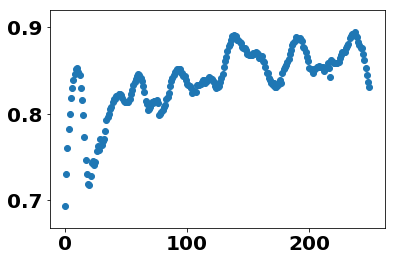

In [32]:
plt.scatter(range(len(scores)), scores)

/home/ajay/.virtualenvs/compression/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


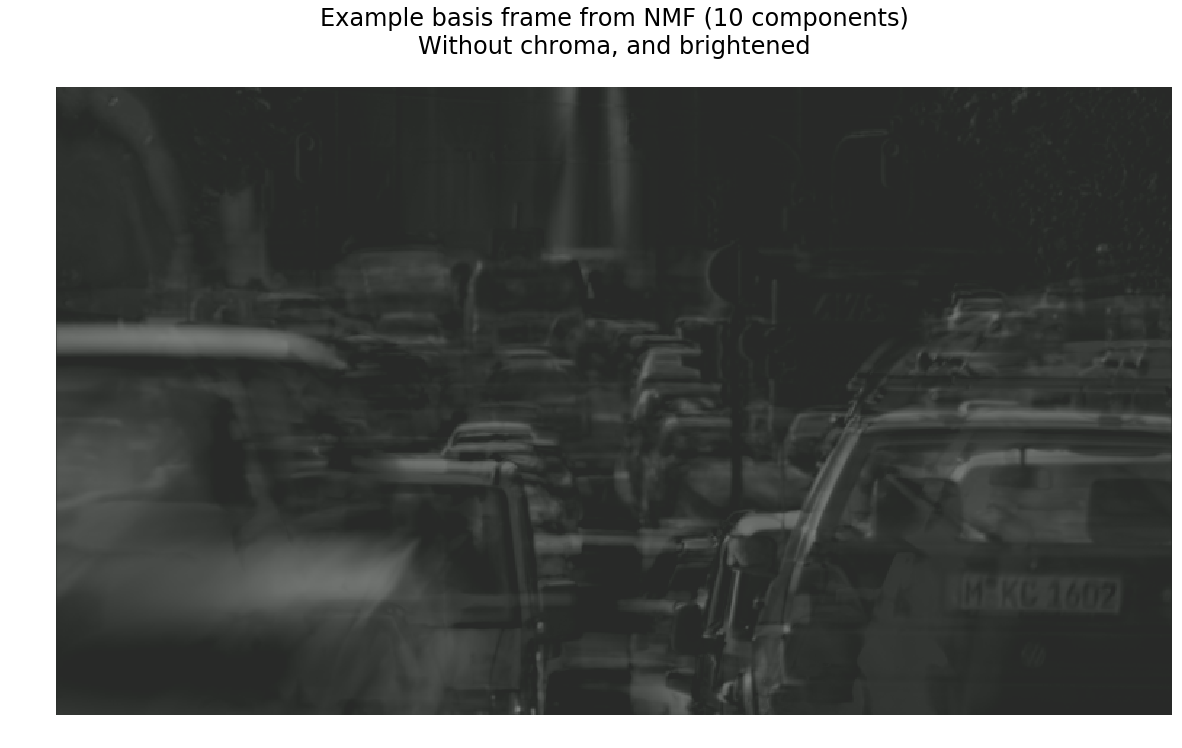

In [97]:
plt.figure(figsize=(20, 30))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
plt.axis("off")
plt.title("Example basis frame from NMF (10 components)\nWithout chroma, and brightened\n")
plt.imshow(np.asarray(frame_vector_to_rgb(np.concatenate((H[9][:331776], np.ones(82944 * 2) * 0.5)), dim)) + 40)
plt.savefig("basis-vector.eps")